<a href="https://colab.research.google.com/github/Zhang-Ronghao/My-prototypical-networks/blob/main/%E7%AC%AC%E4%B8%80%E6%AC%A1%E4%BB%BB%E5%8A%A1ProtoNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototypical Networks


## Imports

In [ ]:
import numpy as np
import os
import cv2
from scipy import ndimage
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torchvision

## Load Data

### on the Omniglot Dataset

In [ ]:
# Download
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
# Unzip to omniglot/ folder
!unzip images_background.zip
!unzip images_evaluation.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: images_evaluation/Mongolian/character28/1386_05.png  
  inflating: images_evaluation/Mongolian/character28/1386_06.png  
  inflating: images_evaluation/Mongolian/character28/1386_07.png  
  inflating: images_evaluation/Mongolian/character28/1386_08.png  
  inflating: images_evaluation/Mongolian/character28/1386_09.png  
  inflating: images_evaluation/Mongolian/character28/1386_10.png  
  inflating: images_evaluation/Mongolian/character28/1386_11.png  
  inflating: images_evaluation/Mongolian/character28/1386_12.png  
  inflating: images_evaluation/Mongolian/character28/1386_13.png  
  inflating: images_evaluation/Mongolian/character28/1386_14.png  
  inflating: images_evaluation/Mongolian/character28/1386_15.png  
  inflating: images_evaluation/Mongolian/character28/1386_16.png  
  inflating: images_evaluation/Mongolian/character28/1386_17.png  
  inflating: images_evaluation/Mongolian/character28/1386_18.png  
  inflating: images_evaluation/Mong

In [ ]:
# Clone the repository
!git clone https://github.com/nerdimite/prototypical_networks

Cloning into 'prototypical_networks'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 67 (delta 34), reused 54 (delta 27), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [ ]:
# cd prototypical_networks/

In [ ]:
def load_characters(root, alphabet):
    '''
    Loads the characters from a given alphabet
    Args:
        root (str): Root directory
        alphabet (str): folder name of alphabet
    Returns:
        (tuple) of:
            (list): images
            (list): labels
    '''
    X = []
    y = []
    
    alphabet_path = os.path.join(root, alphabet)
    characters = os.listdir(alphabet_path)
    
    for char in characters:
        char_path = os.path.join(alphabet_path, char)
        images = os.listdir(char_path)
        
        for img in images:
            image = cv2.imread(os.path.join(char_path, img))
            image = cv2.resize(image, (28, 28)) / 255
            
            # Augmentations to add 3 new classes by rotating each class
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            
            X.extend((image, rotated_90, rotated_180, rotated_270))
            y.extend((f'{alphabet}_{char}_0', 
                      f'{alphabet}_{char}_90', 
                      f'{alphabet}_{char}_180', 
                      f'{alphabet}_{char}_270'))
    
    return X, y

In [ ]:
def load_data(root):
    '''
    Loads the full omniglot dataset from a root directory
    Args:
        root (str): path of omniglot dataset
    Returns:
        (tuple) of:
            (ndarray): images
            (ndarray): labels
    '''
    X_data = []
    y_data = []
    
    alphabets = os.listdir(root)
    for alphabet in tqdm(alphabets):
        X, y = load_characters(root, alphabet)
        X_data.extend(X)
        y_data.extend(y)
    
    return np.array(X_data), np.array(y_data)

In [ ]:
X_train, y_train = load_data('/content/images_background')

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
X_eval, y_eval = load_data('/content/images_evaluation')

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
X_train.shape , y_train.shape , X_eval.shape , y_eval.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

### on MNIST dataset

In [ ]:
!wget https://github.com/Zhang-Ronghao/MNIST/blob/main/mnist_png.tar.gz


--2022-04-01 08:01:25--  https://github.com/Zhang-Ronghao/MNIST/blob/main/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘mnist_png.tar.gz’

mnist_png.tar.gz        [ <=>                ] 124.29K  --.-KB/s    in 0.02s   

2022-04-01 08:01:25 (5.10 MB/s) - ‘mnist_png.tar.gz’ saved [127275]



In [ ]:
!tar zxvf mnist_png.tar.gz


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [ ]:
def load_characters(root):
    '''
    Loads the characters from a given alphabet
    Args:
        root (str): Root directory
        alphabet (str): folder name of alphabet
    Returns:
        (tuple) of:
            (list): images
            (list): labels
    '''
    X = []
    y = []

    alphabet_path = root
    characters = os.listdir(root)
    
    for char in tqdm(characters):
        char_path = os.path.join(alphabet_path, char)
        images = os.listdir(char_path)
        
        for img in images:
            image = cv2.imread(os.path.join(char_path, img))
            image = cv2.resize(image, (28, 28)) / 255
            
            # Augmentations to add 3 new classes by rotating each class
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            
            X.extend((image, rotated_90, rotated_180, rotated_270))
            y.extend((f'_{char}_0', 
                      f'_{char}_90', 
                      f'_{char}_180', 
                      f'_{char}_270'))
    
    return X, y

In [ ]:
def load_data(root):
    '''
    Loads the full omniglot dataset from a root directory
    Args:
        root (str): path of omniglot dataset
    Returns:
        (tuple) of:
            (ndarray): images
            (ndarray): labels
    '''
    X_data = []
    y_data = []
    
    alphabets = os.listdir(root)
    X, y = load_characters(root)
    X_data.extend(X)
    y_data.extend(y)
    
    return np.array(X_data), np.array(y_data)

In [ ]:
X_train, y_train = load_data('/content/mnist_png/training/')

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
X_eval, y_eval = load_data('/content/mnist_png/testing')

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
X_train.shape , y_train.shape , X_eval.shape , y_eval.shape

((240000, 28, 28, 3), (240000,), (40000, 28, 28, 3), (40000,))

## Task Generation

In [ ]:
def extract_sample(X_data, y_data, k_shot=5, n_way=8, n_query=5, permute=True):
    '''
    随机取一个k-shot n-way nquery的task
    Extract a random sample as a k-shot n-way task
    Args:
        X_data (ndarray): images
        y_data (ndarray): labels
        k_shot (int): number of images per class 每个分类里面有k_shot个样本
        n_way (int): number of classes in the task 有n_way个分类
        n_query (int): number of query images 每个分类里面有n_query个查询
        permute (bool): flag to shuffle the classes or not. For training this must be set to True.
    Returns:
        (ndarray): sampled images of shape (n_way, k_shot + n_query, 28, 28, 3)
    '''
    sample = []
    
    # Randomly select n_way classes 
    # 在y_data中随机抽取n个不重复的类
    sampled_cls = np.random.choice(np.unique(y_data), n_way, replace=False)
    
    # Only useful for extracting samples with no query images during prediction on unlablled data
    if not permute:
        sampled_cls = np.unique(y_data)[:n_way]
        

    for c in sampled_cls:
        # Select images belonging to that class
        # 对于每个类，先选出类里面全部的样本
        X_data_c = X_data[y_data == c]
        
        # Sample k_shot+n_query images
        # 用random.permutation()方法对数据重新排序后，选出前 k_shot+n_query 个数据
        sample_images = np.random.permutation(X_data_c)[:(k_shot+n_query)]
        sample.append(sample_images)

    sample = np.array(sample)
    # Convert to tensor and permute the images as channels first
    # 转换成张量,并按channels重排？？
    sample = torch.from_numpy(sample).float().permute(0, 1, 4, 2, 3)
    
    return sample

In [ ]:
def display_sample(sample):
    '''Display the samples of the task as a grid'''
    # Reshape to 4-dimensions from 5-dimensions
    sample_4d = sample.view(sample.shape[0]*sample.shape[1], *sample.shape[2:])
    
    # Make a grid
    out = torchvision.utils.make_grid(sample_4d, nrow=sample.shape[1])
    
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

In [ ]:
test_sample = extract_sample(X_train, y_train, k_shot=5, n_way=8, n_query=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


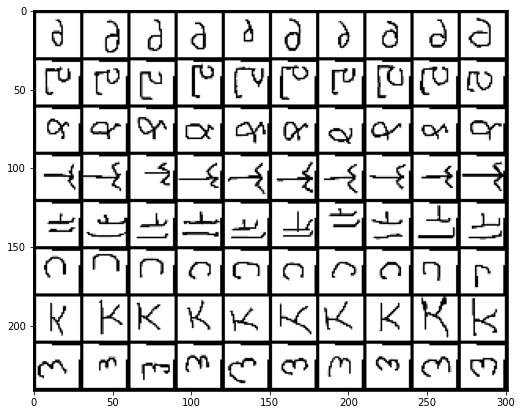

In [ ]:
display_sample(test_sample)

## Model

The embedding part takes a (28x28x3) image and returns a column vector of length 64. The image2vector function is composed of 4 modules. Each module comprises a 64-filter 3 × 3 convolution, a batch normalization layer, a ReLU nonlinearity and a 2 × 2 max-pooling layer.

When applied to the 28 × 28 Omniglot images this architecture results in a 64-dimensional output space.

In [ ]:
class Image2Vector(nn.Module):
    def __init__(self):
        super(Image2Vector, self).__init__()
        
        self.input_block = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))
        
        self.conv_block = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2))
    def forward(self, x):
        #包括四个卷积块，每个卷积块由卷积层，batch normalization ，relu，池化层
        x = self.input_block(x)
        x = self.conv_block(x)
        x = self.conv_block(x)
        x = self.conv_block(x)
        
        # Output of shape (batch_size, 64)
        out = x.view(x.size(0), -1)
        
        return out

In [ ]:
class ProtoNet(nn.Module):
    '''ProtoNet Model for usage with known/labelled data'''
    def __init__(self):
        super(ProtoNet, self).__init__()
        
        self.encoder = Image2Vector()
    
    def forward(self, sample, k_shot, n_way, n_query, device):
        '''Forward pass
        Args:
            sample (torch.Tensor): sample of shape (n_way, k_shot + n_query, 28, 28, 3)
            k_shot (int): number of images per class
            n_way (int): number of classes
            n_query (int): number of query images per class
        
        Returns:
            tuple of:
                loss, dict of loss value, accuracy, predictions
        '''
        # Get the support set and query set images
        # 取出支撑集和查询集
        support = sample[:, :k_shot]
        queries = sample[:, k_shot:]
        
        # Get the target indices
        targets = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long().to(device)
        
        # Concatenate support set and query set along the 0th dimension
        # 连接两个集合
        x = torch.cat([support.contiguous().view(n_way * k_shot, *support.size()[2:]), 
                       queries.contiguous().view(n_way * n_query, *queries.size()[2:])], 0)
        
        # Get the embeddings
        # 嵌入
        embeds = self.encoder(x)
        z_dim = embeds.size(-1)
        
        # Compute Prototypes
        # 支撑集的嵌入部分,通过求均值,得到原型
        protos = embeds[:n_way * k_shot].view(n_way, k_shot, z_dim).mean(1)
        
        # Get query embeddings
        # 取出查询集对应的嵌入部分
        query_embeds = embeds[n_way * k_shot:]
        
        # Compute Distances
        # 计算查询集嵌入和原型之间的欧氏距离
        distances = self.euclidean(query_embeds, protos)
        
        # Compute Log Softmax over the inverse of euclidean distances
        # 利用log softmax 计算出概率
        log_p = F.log_softmax(-distances, dim=1).view(n_way, n_query, -1)
        
        # Compute the negative of log softmax for correct classes (NLL)
        # and calculate the mean NLL loss
        # 计算损失
        loss = -log_p.gather(2, targets).squeeze().view(-1).mean()
                
        # Get predictions and calculate accuracy
        # 计算准确度
        y_hat = log_p.argmax(2)
        accuracy = torch.eq(y_hat, targets.squeeze()).float().mean()
        
        return loss, {'loss': loss.item(), 
                      'preds': y_hat, 
                      'acc': accuracy.item()}
        
        
    def euclidean(self, queries, protos):
        #计算查询和原型之间的欧几里得距离
        '''
        Calculates Euclidean Distances between queries and prototypes
        Args:
            queries (torch.Tensor): shape (n, d) where n is n_way*n_query
            protos (torch.Tensor): shape (m, d) where m is n_way
        Returns:
            (torch.Tensor): shape (n, m) i.e. for each query the euclidean distances
                            to each of the prototypes
        '''
        n = queries.size(0)
        m = protos.size(0)
        d = queries.size(1)
        
        # Reshaping the queries and prototypes for distance calculation
        queries = queries.unsqueeze(1).expand(n, m, d)
        protos = protos.unsqueeze(0).expand(n, m, d)
        
        distance = torch.pow(queries - protos, 2).sum(2) # of shape n x m
        
        return distance

In [ ]:
model = ProtoNet()

## Training

In [ ]:
from tqdm.notebook import tnrange

In [ ]:
def train(model, X_data, y_data, optimizer, device='cuda', 
          k_shot=5, n_way=60, n_query=5, epochs=5, episodes=2000):
    '''
    Trains the ProtoNet on k-shot n-way task
    Args:
        model
        X_data (torch.Tensor): images
        y_data (torch.Tensor): labels
        optimizer
        k_shot (int): number of support images per class
        n_way (int): number of classes
        n_query (int): number of query images per class
        epochs (int): maximum epochs
        episodes (int): number of steps per epoch
    '''
    
    model.to(device)
    model.train()
    # Create LR scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5)
    
    for epoch in range(epochs):
        print('Epoch {:d} Started...'.format(epoch+1))
        train_losses = 0
        train_accuracies = 0
        
        #每个epoch下有多个episode
        for episode in tnrange(episodes, desc='Epoch {:d}'.format(epoch+1)):
            optimizer.zero_grad()
            
            # Extract sample
            sample = extract_sample(X_data, y_data, k_shot, n_way, n_query).to(device)
            
            # Forward Pass on ProtoNet
            loss, stats = model(sample, k_shot, n_way, n_query, device)
            
            # Backprop and Optimize
            loss.backward()
            optimizer.step()
            
            # Get Stats
            train_losses += stats['loss']
            train_accuracies += stats['acc']
            
            if episode % 200 == 0:
                print('At Episode {:d} -- Loss {:.5f} - Acc: {:.3f}'.format(episode, stats['loss'], stats['acc']))
        
        # Print Epoch Stats
        mean_loss = train_losses / episodes
        mean_acc = train_accuracies / episodes
        print('Epoch {:d} -- Loss: {:.5f} - Acc: {:.3f}\n'.format(epoch+1, mean_loss, mean_acc))
        
        # Scheduler Step
        scheduler.step()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
train(model, X_train, y_train, optimizer, device='cuda', k_shot=5, n_way=60, n_query=5, epochs=5, episodes=2000)
#n way 取多少

Epoch 1 Started...


Epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]

At Episode 0 -- Loss 2.51452 - Acc: 0.470
At Episode 200 -- Loss 0.49794 - Acc: 0.820
At Episode 400 -- Loss 0.38575 - Acc: 0.903
At Episode 600 -- Loss 0.36771 - Acc: 0.853
At Episode 800 -- Loss 0.18532 - Acc: 0.947
At Episode 1000 -- Loss 0.30918 - Acc: 0.923
At Episode 1200 -- Loss 0.17753 - Acc: 0.947
At Episode 1400 -- Loss 0.18738 - Acc: 0.940
At Episode 1600 -- Loss 0.12041 - Acc: 0.957
At Episode 1800 -- Loss 0.16161 - Acc: 0.940
Epoch 1 -- Loss: 0.29967 - Acc: 0.908

Epoch 2 Started...


Epoch 2:   0%|          | 0/2000 [00:00<?, ?it/s]

At Episode 0 -- Loss 0.12126 - Acc: 0.973
At Episode 200 -- Loss 0.08792 - Acc: 0.970
At Episode 400 -- Loss 0.17687 - Acc: 0.933
At Episode 600 -- Loss 0.13365 - Acc: 0.947
At Episode 800 -- Loss 0.09793 - Acc: 0.963
At Episode 1000 -- Loss 0.12765 - Acc: 0.970
At Episode 1200 -- Loss 0.17082 - Acc: 0.940
At Episode 1400 -- Loss 0.10346 - Acc: 0.960
At Episode 1600 -- Loss 0.20056 - Acc: 0.950
At Episode 1800 -- Loss 0.05845 - Acc: 0.990
Epoch 2 -- Loss: 0.14846 - Acc: 0.952

Epoch 3 Started...


Epoch 3:   0%|          | 0/2000 [00:00<?, ?it/s]

At Episode 0 -- Loss 0.04226 - Acc: 0.987
At Episode 200 -- Loss 0.07021 - Acc: 0.977
At Episode 400 -- Loss 0.10140 - Acc: 0.967
At Episode 600 -- Loss 0.10608 - Acc: 0.957
At Episode 800 -- Loss 0.14888 - Acc: 0.977
At Episode 1000 -- Loss 0.08250 - Acc: 0.983
At Episode 1200 -- Loss 0.07114 - Acc: 0.980
At Episode 1400 -- Loss 0.06743 - Acc: 0.970
At Episode 1600 -- Loss 0.06451 - Acc: 0.987
At Episode 1800 -- Loss 0.13237 - Acc: 0.953
Epoch 3 -- Loss: 0.12780 - Acc: 0.959

Epoch 4 Started...


Epoch 4:   0%|          | 0/2000 [00:00<?, ?it/s]

At Episode 0 -- Loss 0.13038 - Acc: 0.963
At Episode 200 -- Loss 0.10297 - Acc: 0.963
At Episode 400 -- Loss 0.18262 - Acc: 0.950
At Episode 600 -- Loss 0.05121 - Acc: 0.990
At Episode 800 -- Loss 0.10888 - Acc: 0.950
At Episode 1000 -- Loss 0.08839 - Acc: 0.973
At Episode 1200 -- Loss 0.10091 - Acc: 0.973
At Episode 1400 -- Loss 0.06495 - Acc: 0.973
At Episode 1600 -- Loss 0.07274 - Acc: 0.980
At Episode 1800 -- Loss 0.14950 - Acc: 0.947
Epoch 4 -- Loss: 0.12138 - Acc: 0.960

Epoch 5 Started...


Epoch 5:   0%|          | 0/2000 [00:00<?, ?it/s]

At Episode 0 -- Loss 0.09932 - Acc: 0.970
At Episode 200 -- Loss 0.15191 - Acc: 0.947
At Episode 400 -- Loss 0.16124 - Acc: 0.953
At Episode 600 -- Loss 0.14542 - Acc: 0.953
At Episode 800 -- Loss 0.12921 - Acc: 0.950
At Episode 1000 -- Loss 0.08468 - Acc: 0.973
At Episode 1200 -- Loss 0.07612 - Acc: 0.980
At Episode 1400 -- Loss 0.16422 - Acc: 0.960
At Episode 1600 -- Loss 0.15814 - Acc: 0.957
At Episode 1800 -- Loss 0.08738 - Acc: 0.970
Epoch 5 -- Loss: 0.11967 - Acc: 0.962



In [ ]:
# Save
torch.save(model.state_dict(), 'protonet.pt')

## Evaluation

In [ ]:
def evaluate(model, X_data, y_data, device='cuda', 
             k_shot=5, n_way=5, n_query=5, episodes=1000):
    '''
    Evaluate the ProtoNet on k-shot n-way task on the test set
    Args:
        model
        X_data (torch.Tensor): images
        y_data (torch.Tensor): labels
        k_shot (int): number of support images per class
        n_way (int): number of classes
        n_query (int): number of query images per class
        episodes (int): number of steps/episodes
    '''
    
    model.to(device)
    model.eval()
   
    test_losses = 0
    test_accuracies = 0

    for episode in tnrange(episodes, desc='Evaluating'):            
        # Extract sample
        sample = extract_sample(X_data, y_data, k_shot, n_way, n_query).to(device)

        # Forward Pass on ProtoNet
        loss, stats = model(sample, k_shot, n_way, n_query, device)

        # Get Stats
        test_losses += stats['loss']
        test_accuracies += stats['acc']

        if episode % 200 == 0:
            print('At Episode {:d} -- Loss {:.5f} - Acc: {:.3f}'.format(episode, stats['loss'], stats['acc']))

    # Print Epoch Stats
    mean_loss = test_losses / episodes
    mean_acc = test_accuracies / episodes
    print('Evaluation Results -- Loss: {:.5f} - Acc: {:.3f}\n'.format(mean_loss, mean_acc))

In [ ]:
evaluate(model, X_eval, y_eval, device='cuda', k_shot=5, n_way=5, n_query=5, episodes=1000)

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

At Episode 0 -- Loss 0.00002 - Acc: 1.000
At Episode 200 -- Loss 0.17062 - Acc: 0.960
At Episode 400 -- Loss 0.00128 - Acc: 1.000
At Episode 600 -- Loss 0.01075 - Acc: 1.000
At Episode 800 -- Loss 0.00028 - Acc: 1.000
Evaluation Results -- Loss: 0.02959 - Acc: 0.991



### Test on single sample

In [ ]:
device = 'cuda'
k_shot = 5
n_way = 5
n_query = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


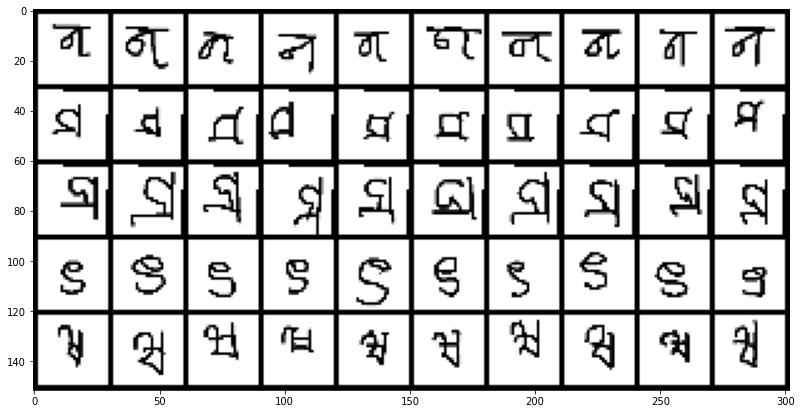

In [ ]:
# Sample a set from test set
my_sample = extract_sample(X_eval, y_eval, k_shot, n_way, n_query).to(device)
display_sample(my_sample.cpu())

In [ ]:
# Predict
loss, stats = model(my_sample, k_shot, n_way, n_query, device)
stats

{'acc': 1.0, 'loss': 0.0025239153765141964, 'preds': tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}